# ***Clustering via $k$-means***

**Clustering** is one of many unsupervised learning methods. In this lab, we'll consider the following form of the clustering task. Suppose you are given

* a set of observations,  $X≡\{\hat{x}_i|0≤i<n\}$ , and
* a target number of clusters,  $k$.

Your goal is to partition the points into $k$ subsets, $C_0,…,C_{k−1}⊆X$, which are

* disjoint, i.e.,  $i≠j⟹C_i∩C_j=∅$ ;
* but also complete, i.e.,  $C_0∪C_1∪⋯∪C_{k−1}=X$.

Intuitively, each cluster should reflect some "sensible" grouping. Thus, we need to specify what constitutes such a grouping.

## Setup: Dataset

In [1]:
#Set up Data
import numpy as np
DATA_PATH = 'materials/'
s1 = 'session_1/'
s2 = 'session_2/'

data = f'{DATA_PATH}{s1}sessionone_data.csv'

compute_d2_test_data = np.load(f'{DATA_PATH}{s1}compute_d2_test_data.npy')
compute_d2_test_soln = np.load(f'{DATA_PATH}{s1}compute_d2_test_soln.npy')

assign_cluster_test_data = np.load(f'{DATA_PATH}{s1}assign_cluster_test_data.npy')
assign_cluster_test_soln = np.load(f'{DATA_PATH}{s1}assign_cluster_test_soln.npy')

update_centers_test_data = np.load(f'{DATA_PATH}{s1}update_centers_test_data.npy')
update_centers_test_soln = np.load(f'{DATA_PATH}{s1}update_centers_test_soln.npy')

img = f"{DATA_PATH}{s2}tiger.bmp"###sitting_girl.jpg"

## The standard $k$ -means algorithm
Finding the global optimum is [NP-hard](https://en.wikipedia.org/wiki/NP-hardness), which is computer science mumbo jumbo for "we don't know whether there is an algorithm to calculate the exact answer in fewer steps than exponential in the size of the input." Nevertheless, there is an iterative method, Lloyd’s algorithm, that can quickly converge to a local (as opposed to global) minimum. The procedure alternates between two operations: assignment and update.

* **Step 1:** Assignment. Given a fixed set of $k$ centers, assign each point to the nearest center:
<center>$C_i= \{\hat{x} :∥\hat{x}−μ_i∥≤∥\hat{x}−μ_j∥,1≤j≤k\}$</center>
<br>

* **Step 2:** Update. Recompute the $k$ centers ("centroids") by averaging all the data points belonging to each cluster, i.e., taking their mean:
<center>$μ_i=\frac{1}{|C_i|}\sum_{\hat{x}∈C_i} \hat{x}$</center>
<br>

In [2]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "http://stanford.edu/~cpiech/cs221/img/kmeansViz.png", width=800, height=800)

In the code that follows, it will be convenient to use our usual "data matrix" convention, that is, each row of a data matrix $X$ is one of $m$ observations and each column (coordinate) is one of  d  predictors. However, we will not need a dummy column of ones since we are not fitting a function.

<center>$X≡ \begin{pmatrix}\hat{x}^{T}_0 \\⋮ \\ \hat{x}^{T}_m \end{pmatrix} =(x_0⋯x_{d−1})$</center>

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from materials.helper_function.helper_function import count_matches,make_scatter_plot

%matplotlib inline

import matplotlib as mpl
mpl.rc("savefig", dpi=100) # Adjust for higher-resolution figures

We will use the following data set.

In [4]:
df = pd.read_csv(data)
df.head()

,x_1,x_2,label
0,31.863397,14.263414,1
1,13.726892,23.971128,0
2,3.197017,29.776102,0
3,14.890682,27.135339,0
4,32.573458,16.689273,1


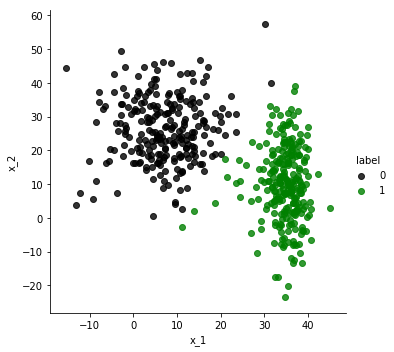

In [5]:
make_scatter_plot(df)

Let's extract the data points as a data matrix, points, and the labels as a vector, labels. Note that the k-means algorithm you will implement should **not** reference labels -- that's the solution we will try to predict given only the point coordinates (points) and target number of clusters (k).

In [6]:
points = df[['x_1', 'x_2']].values
labels = df['label'].values
n, d = points.shape
k = 2

Note that the labels should not be used in the  k -means algorithm. We use them here only as ground truth for later verification.

#### **How to start? Initializing the $k$ centers**

To start the algorithm, you need an initial guess. Let's randomly choose $k$ observations from the data.

**Exercise 1**. Complete the following function, init_centers($X$, $k$), so that it randomly selects $k$ of the given observations to serve as centers. It should return a Numpy array of size k-by-d, where d is the number of columns of $X$.

In [7]:
def init_centers(X, k):
    """
    Randomly samples k observations from X as centers.
    Returns these centers as a (k x d) numpy array.
    """
    ### BEGIN SOLUTION
    from numpy.random import choice
    samples = choice(len(X), size=k, replace=False)
    return X[samples, :]
    ### END SOLUTION

In [8]:
# Test cell: `init_centers_test`

centers_initial = init_centers(points, k)
print("Initial centers:\n", centers_initial)

assert type(centers_initial) is np.ndarray, "Your function should return a Numpy array instead of a {}".format(type(centers_initial))
assert centers_initial.shape == (k, d), "Returned centers do not have the right shape ({} x {})".format(k, d)
assert (sum(centers_initial[0, :] == points) == [1, 1]).all(), "The centers must come from the input."
assert (sum(centers_initial[1, :] == points) == [1, 1]).all(), "The centers must come from the input."

print("\n(Passed!)")

Initial centers:
 [[ 0.35862484 16.194224  ]
 [32.30395042 13.8358833 ]]

(Passed!)


#### **Computing the distances**
**Exercise 2**. Implement a function that computes a distance matrix, $S=(s_{ij})$  such that $s_{ij}=d_{ij}^2$ is the squared distance from point $x^i$ to center $μ_j$. It should return a Numpy matrix S[:m, :k].

In [9]:
def compute_d2(X, centers):
    ### BEGIN SOLUTION
    return compute_d2__1(X, centers)
    
# Method 0: Explicit loop over points (rows of X)
def compute_d2__0(X, centers):
    m = len(X)
    k = len(centers)
    S = np.empty((m, k))
    for i in range(m):
        d_i = np.linalg.norm(X[i, :] - centers, ord=2, axis=1)
        S[i, :] = d_i**2
    return S

# Method 1: Exploit the broadcasting rule (one-line solution!)
def compute_d2__1(X, centers):
    return np.linalg.norm(X[:, np.newaxis, :] - centers, ord=2, axis=2) ** 2
    ### END SOLUTION

In [10]:
# Test cell: `compute_d2_test`

S = compute_d2 (points, compute_d2_test_data)
assert (np.linalg.norm (S - compute_d2_test_soln, axis=1) <= (20.0 * np.finfo(float).eps)).all()

print("\n(Passed!)")


(Passed!)


**Exercise 3**. Write a function that uses the (squared) distance matrix to assign a "cluster label" to each point.

That is, consider the $m×k$ squared distance matrix $S$. For each point $i$, if $s_{i,j}$ is the minimum squared distance for point $i$, then the index $j$ is $i$'s cluster label. In other words, your function should return a (column) vector $y$ of length $m$ such that

\begin{equation*}
y_i=argmin(s_{ij}), 
j∈{0,…,k−1}.
\end{equation*}


In [11]:
def assign_cluster_labels(S):
    ### BEGIN SOLUTION
    return np.argmin(S, axis=1)
    ### END SOLUTION

# Cluster labels:     0    1
S_test1 = np.array([[0.3, 0.2],  # --> cluster 1
                    [0.1, 0.5],  # --> cluster 0
                    [0.4, 0.2]]) # --> cluster 1
y_test1 = assign_cluster_labels(S_test1)
print("You found:", y_test1)

assert (y_test1 == np.array([1, 0, 1])).all()

You found: [1 0 1]


In [12]:
# Test cell: `assign_cluster_labels_test`

y_test2 = assign_cluster_labels(assign_cluster_test_data)
assert (y_test2 == assign_cluster_test_soln).all()

print("\n(Passed!)")


(Passed!)


**Exercise 4**. Given a clustering (i.e., a set of points and assignment of labels), compute the center of each cluster.

In [13]:
def update_centers(X, y):
    # X[:m, :d] == m points, each of dimension d
    # y[:m] == cluster labels
    m, d = X.shape
    k = max(y) + 1
    assert m == len(y)
    assert (min(y) >= 0)
    
    centers = np.empty((k, d))
    for j in range(k):
        # Compute the new center of cluster j,
        # i.e., centers[j, :d].
        ### BEGIN SOLUTION
        centers[j, :d] = np.mean(X[y == j, :], axis=0)
        ### END SOLUTION
    return centers

In [14]:
# Test cell: `update_centers_test`

centers_test3 = update_centers(points, update_centers_test_data)

delta_test3 = np.abs(centers_test3 - update_centers_test_soln)
assert (delta_test3 <= 2.0*len(update_centers_test_soln)*np.finfo(float).eps).all()

print("\n(Passed!)")


(Passed!)


**Exercise 5**. Given the squared distances, return the within-cluster sum of squares.

In particular, your function should have the signature,

> ```python 
def WCSS(S): 
    ...
```     

where S is an array of distances as might be computed from Exercise 2.

For example, suppose S is defined as follows:
> ~~~python
S = np.array([[0.3, 0.2],
              [0.1, 0.5],
              [0.4, 0.2]])
~~~

Then WCSS(S) == 0.2 + 0.1 + 0.2 == 0.5.
> Hint: See [numpy.amin](https://docs.scipy.org/doc/numpy/reference/generated/numpy.amin.html#numpy.amin).

In [15]:
def WCSS(S):
    ### BEGIN SOLUTION
    return np.sum(np.amin(S, axis=1))
    ### END SOLUTION
    
# Quick test:
print("S ==\n", S_test1)
WCSS_test1 = WCSS(S_test1)
print("\nWCSS(S) ==", WCSS(S_test1))

S ==
 [[0.3 0.2]
 [0.1 0.5]
 [0.4 0.2]]

WCSS(S) == 0.5


In [16]:
# Test cell: `WCSS_test`

assert np.abs(WCSS_test1 - 0.5) <= 3.0*np.finfo(float).eps, "WCSS(S_test1) should be close to 0.5, not {}".format(WCSS_test1)
print("\n(Passed!)")


(Passed!)


Lastly, here is a function to check whether the centers have "moved," given two instances of the center values. It accounts for the fact that the order of centers may have changed.

In [17]:
def has_converged(old_centers, centers):
    return set([tuple(x) for x in old_centers]) == set([tuple(x) for x in centers])

**Exercise 6**. Put all of the preceding building blocks together to implement $k$-means algorithm.

In [18]:
def kmeans(X, k,
           starting_centers=None,
           max_steps=np.inf):
    
    if starting_centers is None:
        centers = init_centers(X, k)
    else:
        centers = starting_centers
        
    converged = False
    labels = np.zeros(len(X))
    i = 1
    while (not converged) and (i <= max_steps):
        old_centers = centers
        ### BEGIN SOLUTION
        S = compute_d2(X, centers)
        labels = assign_cluster_labels(S)
        centers = update_centers(X, labels)
        converged = has_converged(old_centers, centers)
        ### END SOLUTION
        print ("iteration", i, "WCSS = ", WCSS (S))
        i += 1
    return labels

In [19]:
clustering = kmeans(points, k, starting_centers=points[[0, 187], :])

iteration 1 WCSS =  100118.16946778112
iteration 2 WCSS =  73036.54279820892
iteration 3 WCSS =  72771.07638156727
iteration 4 WCSS =  72766.36890486747


Let's visualize the results.

500 matches out of 500 possible (~ 100.0%)


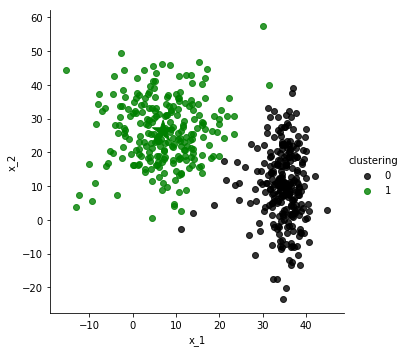

In [20]:
# Test cell: `kmeans_test`

df['clustering'] = clustering
centers = update_centers(points, clustering)
make_scatter_plot(df, hue='clustering', centers=centers)

n_matches = count_matches(df['label'], df['clustering'])
print(n_matches,
      "matches out of",
      len(df), "possible",
      "(~ {:.1f}%)".format(100.0 * n_matches / len(df)))

assert n_matches >= 320

___________________________________

**Applying k-means to an image.** In this section of the notebook, you will apply k-means to an image, for the purpose of doing a "stylized recoloring" of it. (You can view this example as a primitive form of [artistic style transfer](http://genekogan.com/works/style-transfer/), which state-of-the-art methods today [accomplish using neural networks](https://medium.com/artists-and-machine-intelligence/neural-artistic-style-transfer-a-comprehensive-look-f54d8649c199).)

In particlar, let's take an input image and cluster pixels based on the similarity of their colors. Maybe it can become the basis of your own Instagram filter!

In [21]:
from matplotlib.pyplot import imshow
%matplotlib inline
from PIL import Image
def read_img(path):
    """
    Read image and store it as an array, given the image path. 
    Returns the 3 dimensional image array.
    """
    img = Image.open(path)
    img_arr = np.array(img, dtype='int32')
    img.close()
    return img_arr

def display_image(arr):
    """
    display the image
    input : 3 dimensional array
    """
    arr = arr.astype(dtype='uint8')
    img = Image.fromarray(arr, 'RGB')
    imshow(np.asarray(img))

Shape of the matrix obtained by reading the image
(354, 630, 3)


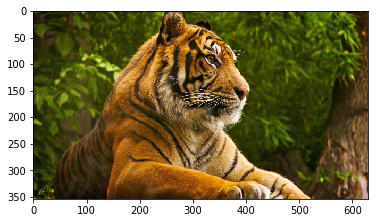

In [22]:
img_arr = read_img(img)
display_image(img_arr)
print("Shape of the matrix obtained by reading the image")
print(img_arr.shape)

Note that the image is stored as a "3-D" matrix. It is important to understand how matrices help to store a image. Each pixel corresponds to a intensity value for Red, Green and Blue. If you note the properties of the image, its resolution is 620 x 412. The image width is 620 pixels and height is 412 pixels, and each pixel has three values - R, G, B. This makes it a 412 x 620 x 3 matrix.

**Exercise 1**. Write some code to reshape the matrix into "img_reshaped" by transforming "img_arr" from a "3-D" matrix to a flattened "2-D" matrix which has 3 columns corresponding to the RGB values for each pixel. In this form, the flattened matrix must contain all pixels and their corresponding RGB intensity values. The numpy reshape function may be of help here.

In [23]:
### BEGIN SOLUTION
r, c, l = img_arr.shape
img_reshaped = np.reshape(img_arr, (r*c, l), order="C")
### END SOLUTION

In [24]:
# Test cell - 'reshape_test'
r, c, l = img_arr.shape
# The reshaped image is a flattened '2-dimensional' matrix
assert len(img_reshaped.shape) == 2
r_reshaped, c_reshaped = img_reshaped.shape
assert r * c * l == r_reshaped * c_reshaped
assert c_reshaped == 3
print("Passed!")

Passed!


**Exercise 2**. Now use the k-means function that you wrote above to divide the image in 3 clusters. The result would be a vector named labels, which assigns the label to each pixel.

In [25]:
### BEGIN SOLUTION
labels = kmeans(img_reshaped, 3)
### END SOLUTION

iteration 1 WCSS =  1138681263.0
iteration 2 WCSS =  433683902.9492175
iteration 3 WCSS =  369917967.25038904
iteration 4 WCSS =  353071539.6825964
iteration 5 WCSS =  342223883.9150342
iteration 6 WCSS =  335331378.8751496
iteration 7 WCSS =  330851385.1649492
iteration 8 WCSS =  327912802.46395105
iteration 9 WCSS =  325994918.7855698
iteration 10 WCSS =  324775172.3724239
iteration 11 WCSS =  323933115.4918238
iteration 12 WCSS =  323330618.9533019
iteration 13 WCSS =  322879118.6985769
iteration 14 WCSS =  322576614.4667095
iteration 15 WCSS =  322376292.745612
iteration 16 WCSS =  322234044.80623275
iteration 17 WCSS =  322136490.2161114
iteration 18 WCSS =  322073215.77476805
iteration 19 WCSS =  322025632.51991767
iteration 20 WCSS =  321992959.5055352
iteration 21 WCSS =  321972941.43816286
iteration 22 WCSS =  321959042.68925375
iteration 23 WCSS =  321947421.39875776
iteration 24 WCSS =  321938404.7690442
iteration 25 WCSS =  321931472.5385752
iteration 26 WCSS =  321925924.7

In [26]:
# Test cell - 'labels'
assert len(labels) == r_reshaped
assert set(labels) == {0, 1, 2}
print("\nPassed!")


Passed!


**Exercise 3**. Write code to calculate the mean of each cluster and store it in a dictionary, named centers, as label:array(cluster_center). For 3 clusters, the dictionary should have three keys as the labels and their corresponding cluster centers as values, i.e. {0:array(center0), 1: array(center1), 2:array(center2)}.

In [27]:
### BEGIN SOLUTION
ind = np.column_stack((img_reshaped, labels))
centers = {}
for i in set(labels):
    c = ind[ind[:,3] == i].mean(axis=0)
    centers[i] = c[:3]
### END SOLUTION

Below, we have written code to generate a matrix "img_clustered" of the same dimensions as img_reshaped, where each pixel is replaced by the cluster center to which it belongs.

In [28]:
img_clustered = np.array([centers[i] for i in labels])

Let us display the clustered image and see how kmeans works on the image.

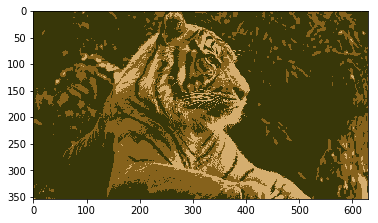

In [29]:
r, c, l = img_arr.shape
img_disp = np.reshape(img_clustered, (r, c, l), order="C")
display_image(img_disp)

You can visually inspect the original image and the clustered image to get a sense of what kmeans is doing here. You can also try to vary the number of clusters to see how the output image changes

____________________________

# **Built-in $k$-means**

The preceding exercises walked you through how to implement $k$-means, but as you might have imagined, there are existing implementations as well! The following shows you how to use Sklearn's implementation, which should yield similar results. If you are asked to use $k$-means in a future, you can use this one.

In [30]:
from sklearn.cluster import KMeans

In [31]:
# Defining the cluster model using sklearn KMeans

k = 5
kmeans_sklearn = KMeans(k)
kmeans_sklearn

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [32]:
# Training/Clustering the data point

img_reshaped_sklearn = kmeans_sklearn.fit(img_reshaped)
label_sklearn = img_reshaped_sklearn.labels_

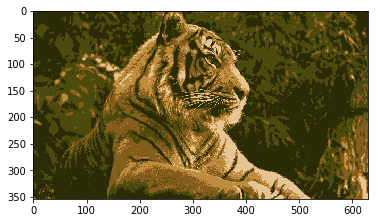

In [33]:
# Recreating Image from a given cluster

ind = np.column_stack((img_reshaped, label_sklearn))

centers = {}
for i in set(label_sklearn):
    c = ind[ind[:,3] == i].mean(axis=0)
    centers[i] = c[:3]
    
img_clustered_sklearn = np.array([centers[i] for i in label_sklearn])

r, c, l = img_arr.shape
img_disp = np.reshape(img_clustered_sklearn, (r, c, l), order="C")
display_image(img_disp)